# Building simple ANN with backpropagation tested with MNIST data
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

More detail, please check: http://yann.lecun.com/exdb/mnist/

It has also been integrated into sklean package, so it can be directly imported.

(1797, 8, 8)
(1797, 64)


<Figure size 432x288 with 0 Axes>

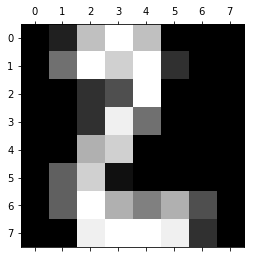

In [9]:
# loading MNIST data
from sklearn.datasets import load_digits
digits = load_digits()
# digits image data which has been converted into three dimensional array
print(digits.images.shape)
# data has been concantenated into a vector by order
print(digits.data.shape)

import numpy as np
import matplotlib.pyplot as plt
plt.gray()
ran_img = np.random.choice(range(digits.images.shape[0]))
plt.matshow(digits.images[ran_img])
plt.show()

### Preprocessing data
* Standardize x
* Split training and testing set
* Create dummy output for classification

In [11]:
# standardize data into zscore
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
print(X[0,:])

# create training and testing set
from sklearn.model_selection import train_test_split
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# convert y value into vector of zeros and one, dummy variable
import numpy as np
def vectorize_y(y):
    y_vec = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vec[i,y[i]] = 1
    return y_vec
y_train = vectorize_y(y_train)
y_test  = vectorize_y(y_test)
print(y_train[0],y_test[0])

[ 0.         -0.33501649 -0.04308102  0.27407152 -0.66447751 -0.84412939
 -0.40972392 -0.12502292 -0.05907756 -0.62400926  0.4829745   0.75962245
 -0.05842586  1.12772113  0.87958306 -0.13043338 -0.04462507  0.11144272
  0.89588044 -0.86066632 -1.14964846  0.51547187  1.90596347 -0.11422184
 -0.03337973  0.48648928  0.46988512 -1.49990136 -1.61406277  0.07639777
  1.54181413 -0.04723238  0.          0.76465553  0.05263019 -1.44763006
 -1.73666443  0.04361588  1.43955804  0.         -0.06134367  0.8105536
  0.63011714 -1.12245711 -1.06623158  0.66096475  0.81845076 -0.08874162
 -0.03543326  0.74211893  1.15065212 -0.86867056  0.11012973  0.53761116
 -0.75743581 -0.20978513 -0.02359646 -0.29908135  0.08671869  0.20829258
 -0.36677122 -1.14664746 -0.5056698  -0.19600752]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### Define ANN functions

In [75]:
# define NN structure
nn_structure = [64,30,10]

# define activation function
def f(x):
    return 1/(1 + np.exp(-x))

# define derivative of activation function
def f_deriv(x):
    return f(x) * (1 - f(x))

# define function for initializing weights and bias
def weight_initialization(nn_structure):
    W = {}
    b = {}
    for sl in range(1, len(nn_structure)):
        W[sl] = np.random.random_sample((nn_structure[sl], nn_structure[sl - 1]))
        b[sl] = np.random.random_sample((nn_structure[sl],))
    return W, b

# define function for creating weight and bias updates
def delta_initialization(nn_structure):
    delta_W = {}
    delta_b = {}
    for sl in range(1, len(nn_structure)):
        delta_W[sl] = np.zeros((nn_structure[sl], nn_structure[sl - 1]))
        delta_b[sl] = np.zeros((nn_structure[sl],))
    return delta_W, delta_b

# define function for feedforward
def feed_forward(x, W, b):
    h = {1:x}
    z = {}
    for sl in range(1, len(W)+1):
        if sl == 1:
            node_in = x
        else:
            node_in = h[sl]
        z[sl+1] = W[sl].dot(node_in) + b[sl]
        h[sl+1] = f(z[sl+1])
    return h, z

# calculate gradient at output layer
def calculate_gradient_last_layer(y, h_out, z_out):
    return -(y - h_out) * f_deriv(z_out)

# calculate gradient at hidden layers
def calculate_gradient_hidden_layer(delta_plus_1, w_sl, z_sl):
    return np.dot(np.transpose(w_sl), delta_plus_1) * f_deriv(z_sl)


### Define ANN training

In [80]:
def train_nn(nn_structure, X, y, iter_num = 3000, alpha = 0.25):
    W, b = weight_initialization(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print("Gradient decent stated for {} iteration".format(iter_num))
    
    while cnt <= iter_num:
        if cnt % 1000 == 0:
            print("Finshed {} out of {}".format(cnt, iter_num))
        delta_W, delta_b = delta_initialization(nn_structure)
        avg_cost = 0
        
        for i in range(len(y)):
            delta = {}
            h, z = feed_forward(X[i, :], W, b)
            
            for sl in range(len(nn_structure), 0, -1):
                if sl == len(nn_structure):
                    delta[sl] = calculate_gradient_last_layer(y[i,:], h[sl], z[sl])
                    avg_cost += np.linalg.norm(y[i,:]-h[sl])
                else:
                    if sl > 1:
                        delta[sl] = calculate_gradient_hidden_layer(delta[sl+1], W[sl], z[sl])
                    delta_W[sl] += np.dot(delta[sl+1][:,np.newaxis], np.transpose(h[sl][:,np.newaxis]))
                    delta_b[sl] += delta[sl+1]
                    
        for sl in range(len(nn_structure)-1,0,-1):
            W[sl] += -alpha * (1.0/m * delta_W[sl])
            b[sl] += -alpha * (1.0/m * delta_b[sl])
        avg_cost = avg_cost / m
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

In [81]:
W, b, avg_cost_func = train_nn(nn_structure, X=X_train, y=y_train)

Gradient decent stated for 3000 iteration
Finshed 0 out of 3000
Finshed 1000 out of 3000
Finshed 2000 out of 3000
Finshed 3000 out of 3000


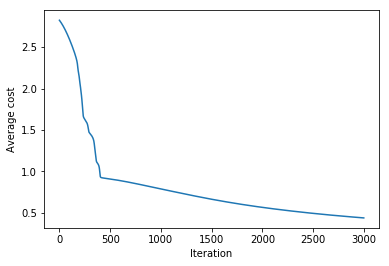

In [83]:
plt.plot(avg_cost_func)
plt.ylabel('Average cost')
plt.xlabel('Iteration')
plt.show()